In [3]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define the dictionary of digit segments so we can identify
# each digit on the thermostat

image = cv2.imread('./sample0.jpg')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.bilateralFilter(gray, 11, 17, 17)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

sigma = 0.33
v = np.median(blurred)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edged = cv2.Canny(blurred, 0, 200, 255)


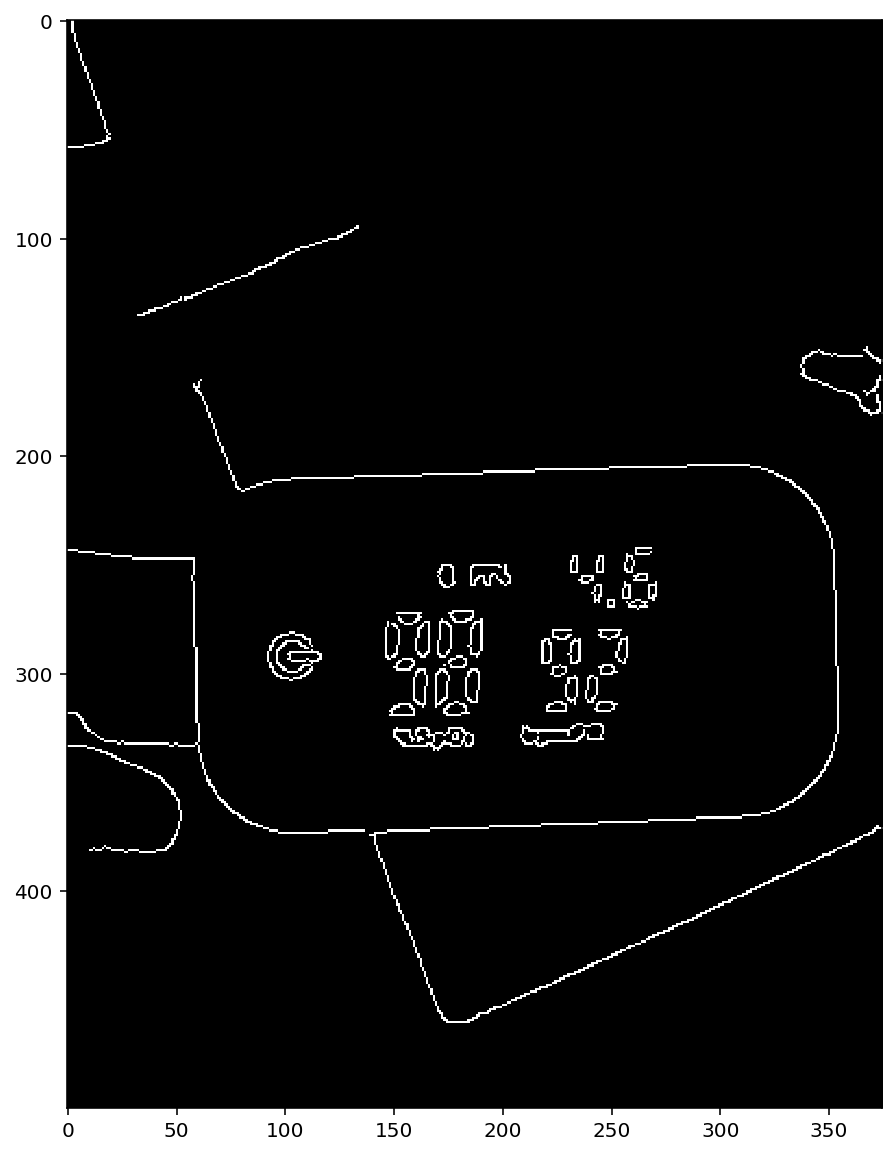

In [6]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
def draw_line(rho, theta, img):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)    

def draw_cline(y1, x1, y2, x2, img):
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)  
    

<Figure size 1440x720 with 0 Axes>

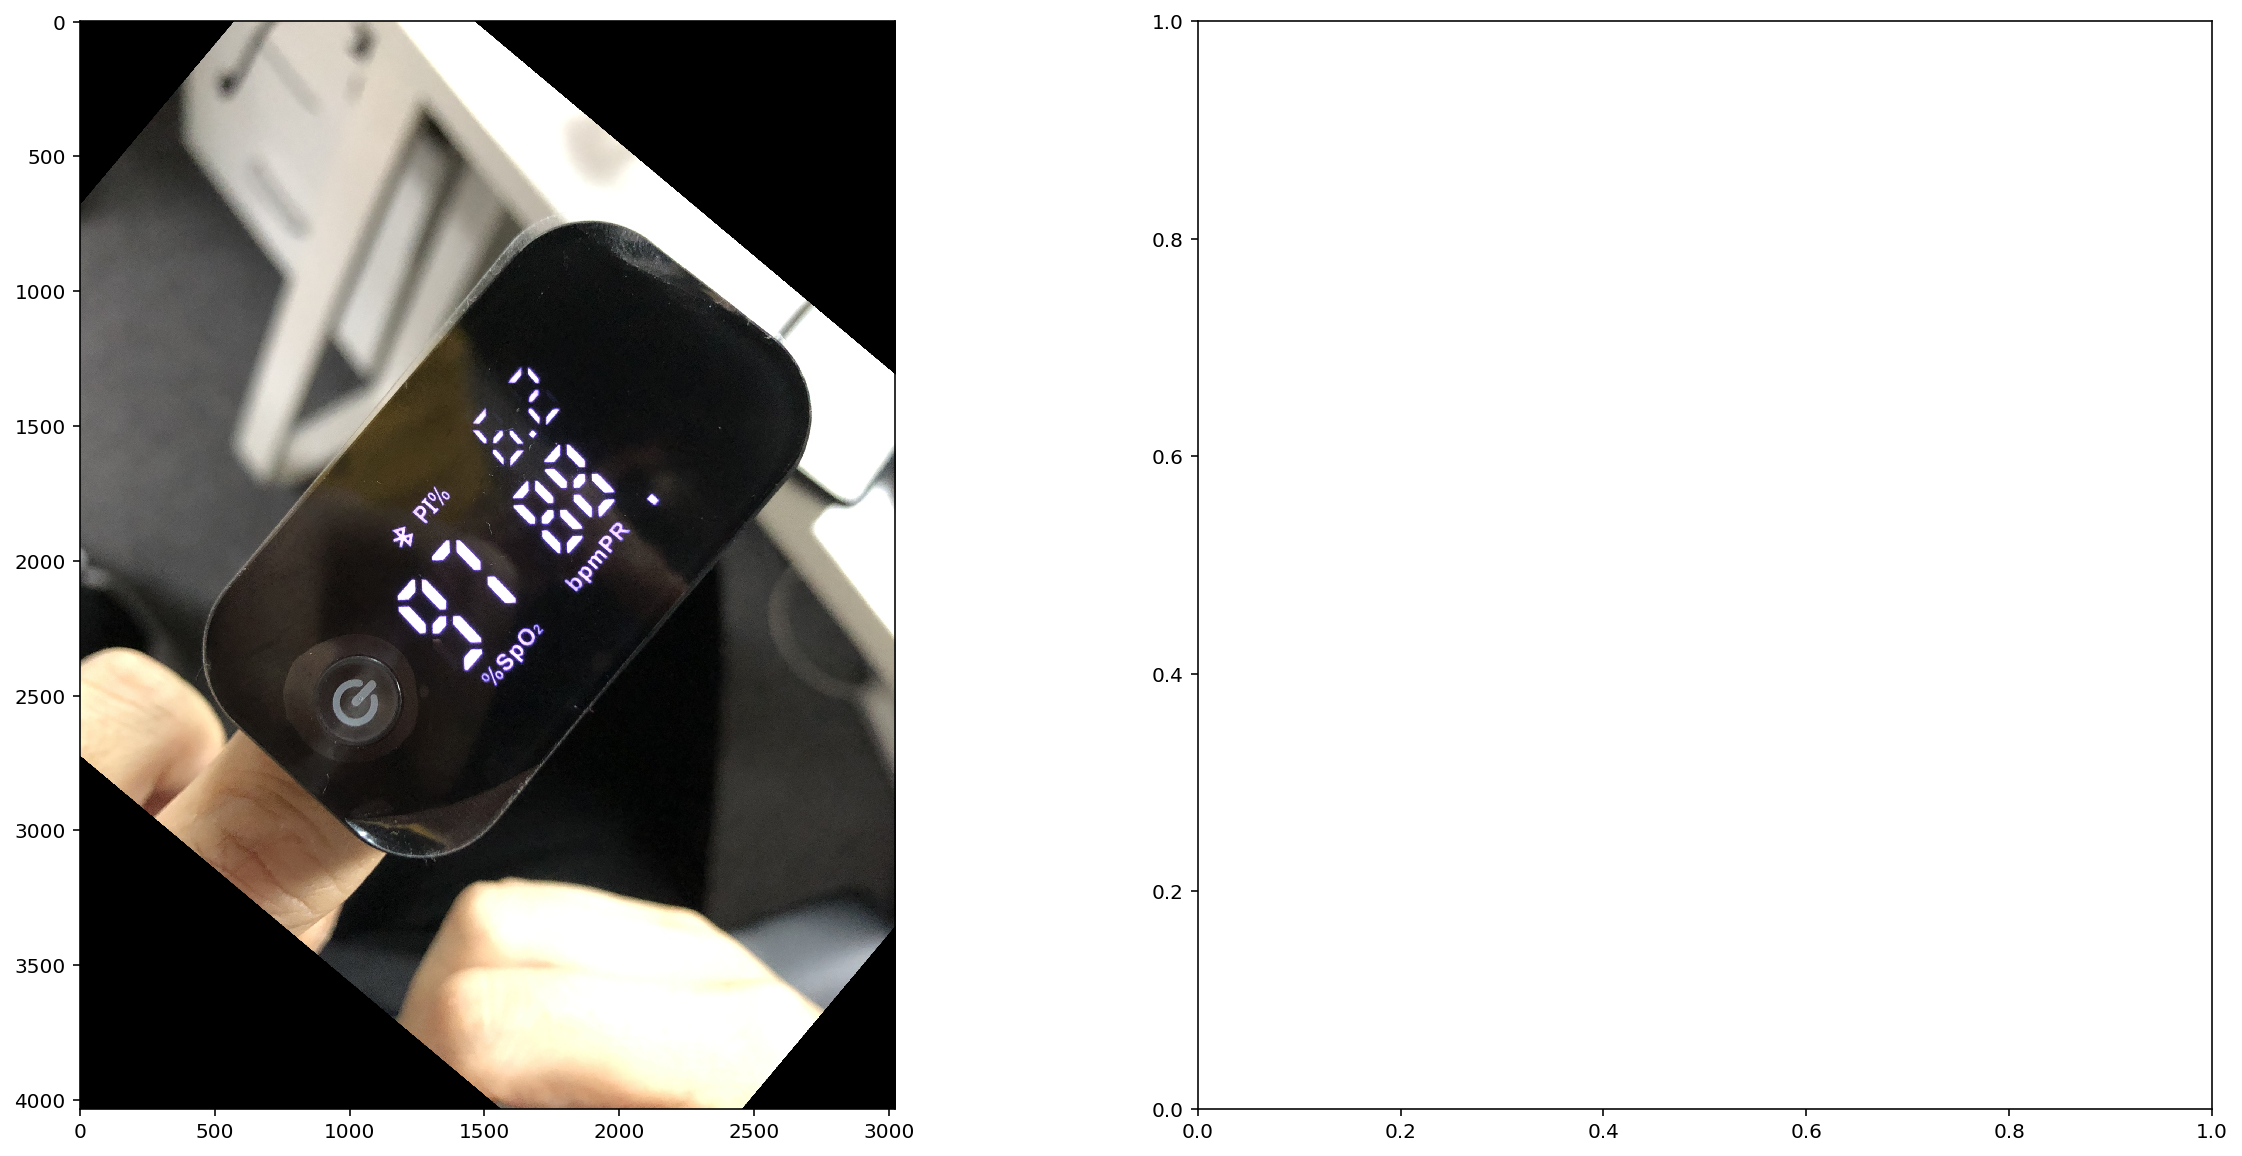

In [28]:
def find_screen(org_image):
    org_image = imutils.resize(org_image, height=500)
    imh = org_image.shape[0]
    imw = org_image.shape[1]
    cropL = 120
    cropR = 254
    
    image = org_image[:, cropL:cropR]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,31, 2)  
    edged = cv2.Canny(th2, 0, 100, 255)
    
    lines = cv2.HoughLines(edged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
    lines = np.append(lines, [[[i]] for i in range(len(lines))], axis=2) #mark by order of feature strength
    
    #merge similar lines
    idx = 0 
    while idx < len(lines):
        for jdx in range(idx):
            ri, ti, _ = lines[idx][0]
            rj, tj, _ = lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                lines = np.delete(lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #find pairs of horizontal parallel lines
    parallel_lines = []
    for i in range(len(lines)):
        for j in range(len(lines)):
            if j == i: continue
            ri, ti, si = lines[i][0]
            rj, tj, sj = lines[j][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            #parallel, some distance apart, horizontal
            if dt < 0.1 and 75<dp<200 and 1.40<ti<1.70: 
                parallel_lines.append([ri, ti, si, rj, tj, sj])

    parallel_lines.sort(key=lambda p: (p[2]*p[2]+p[5]*p[5]))  #sort by feature strength
    parallel_lines = parallel_lines[:5]
    
    #the screen has bright digits surrounded by a dark background
    #look for this pattern of brightness
    hsvim = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    row_color = np.array([hsvim[i,:,2].max(axis=0) - hsvim[i,:,2].min(axis=0) for i in range(len(hsvim))])
    row_color = np.expand_dims(row_color, axis=1)
    
    best_score = -10**10
    long_edges = None
    for ri, ti, si, rj, tj, sj in parallel_lines:
        hi = int(ri*np.sin(ti))
        hj = int(rj*np.sin(tj))
        region = row_color[min(hi,hj):max(hi,hj), :]
        l = len(region)
        margin = 0.2
        top_value = np.mean(region[:int(margin*l), :])
        btm_value = np.mean(region[-int(margin*l):, :])
        mid_value = np.mean(region[int(margin*l):-int(margin*l), :])
        score = mid_value - 2*(top_value+btm_value)/2   #weighted
        if score > best_score:
            best_score = score
            long_edges = [ri, ti, rj, tj]
    
    if long_edges[0] < long_edges[2]: 
        top_edge = long_edges[:2]
        btm_edge = long_edges[2:]
    else:
        top_edge = long_edges[2:]
        btm_edge = long_edges[:2]
    
    #convert to coordinates in original image
    def endpt_b4_crop(r, t):
        hleft = int((1+cropL*np.cos(t)/r) * r/np.sin(t))
        hright = int((1+(cropL-imw)*np.cos(t)/r) * r/np.sin(t))
        return (0, hleft, imw, hright)
        
    top_endpt = endpt_b4_crop(*top_edge)
    btm_endpt = endpt_b4_crop(*btm_edge)
    
    #might want to crop a rectangle (now a parallelogram)
    screen_row = four_point_transform(org_image, np.array([top_endpt[:2],top_endpt[2:],btm_endpt[2:],btm_endpt[:2]]))
    rgray = cv2.cvtColor(screen_row, cv2.COLOR_BGR2GRAY)
    rblur = cv2.GaussianBlur(rgray,(5,5),0)
    rth2 = cv2.adaptiveThreshold(rblur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,101, 2)  #important parameter
    
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(rth2, cv2.MORPH_CLOSE, kernel)
    col_mean_V = np.mean(closing, axis=0)
    
    #find darkest horizontal region
    expected_width = int(len(screen_row) * 1.8)  #slightly wider
    best_score = -10**6
    best_window = 0
    for window_start in range(len(col_mean_V)-expected_width):
        score = -np.mean(col_mean_V[window_start:window_start+expected_width])  #this can be optimized for speed
        if score > best_score:
            best_score = score
            best_window = window_start
    
    approx_screen = screen_row[:, best_window:best_window+expected_width,:]
    rth2 = rth2[:, best_window:best_window+expected_width]
    
    redged = cv2.Canny(rth2, 0, 100, 255)
    screen_lines = cv2.HoughLines(redged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
   
    #merge similar lines
    idx = 0 
    while idx < len(screen_lines):
        for jdx in range(idx):
            ri, ti = screen_lines[idx][0]
            rj, tj = screen_lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                screen_lines = np.delete(screen_lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #now look the screen's vertical borders
    vertical_lines = []
    for screen_line in screen_lines:
        for r, t in screen_line:
            if -0.1<t<0.1:
                vertical_lines.append([r, t])
    vertical_lines.sort(key=lambda v: v[0])
    
    #don't crop if screen is already bordered by the previous crop
    if vertical_lines[0][0]*np.cos(vertical_lines[0][1]) < expected_width * 1/8:
        left_edge = int(vertical_lines[0][0]*np.cos(vertical_lines[0][1]))
    else:
        left_edge = 0
    
    if vertical_lines[-1][0]*np.cos(vertical_lines[-1][1]) > expected_width * 7/8:
        right_edge = int(vertical_lines[-1][0]*np.cos(vertical_lines[-1][1]))
    else:
        right_edge = expected_width
        
    screen = approx_screen[:,left_edge:right_edge]
    screen = cv2.resize(screen, (350, 200))
    #screen = imutils.rotate(screen, top_edge[1]/np.pi*180-90)
    
    return screen


#ret = test('./images/IMG_2836.JPG')
#plt.imshow(ret)
#plt.show()
#plt.figure()
#f, ax = plt.subplots(2, 5)
#for imdx in range(10):
#    ax[imdx//5][imdx%5].imshow(test('./images/IMG_'+str(2821+imdx)+'.JPG'))
    
img = cv2.imread('./images/IMG_2843.JPG')
plt.figure()
f, ax = plt.subplots(1, 2)
rotated = imutils.rotate(img, 50)
ax[0].imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
#ax[1].imshow(cv2.cvtColor(find_screen(rotated), cv2.COLOR_BGR2RGB))
plt.show()
    
#[85:145, 183:243]
#[70:145,95:170]
#[40:90,200:260]


In [448]:
def find_digits(screen, segment_area_fraction, width, shear=0.0, has_decimal_pt=False):
    imh, imw, _ = screen.shape 

    #straighten italic digits
    if shear:
        M2 = np.float32([[1, shear, 0], [0, 1, 0]])
        M2[0,2] = -M2[0,1] * imw/2
        M2[1,2] = -M2[1,0] * imh/2
        screen = cv2.warpAffine(screen, M2, (imw, imh))
    
    gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
    blurred = cv2.blur(gray,ksize=(15,15))
    dst = cv2.addWeighted(gray, 4, blurred, -4, 128)     #eliminate background illumination
    dst = np.minimum(dst, np.ones(dst.shape) * 255)
    dst = np.maximum(dst, np.zeros(dst.shape)).astype(np.uint8)
    thresh = cv2.threshold(dst,200,255,cv2.THRESH_BINARY)[1]
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    def bounding_rect(rect1, rect2):
        x1, y1, w1, h1 = rect1
        x2, y2, w2, h2 = rect2
        x = int(min(x1, x2))
        y = int(min(y1, y2))
        w = int(max(x1+w1, x2+w2) - x)
        h = int(max(y1+h1, y2+h2) - y)
        return (x, y, w, h)
    
    #find rectangular bound for digit display
    digit_boundary = (int(imw/2), int(imh/2), 0, 0)
    for cnt in cnts:
        (x, y, w, h) = cv2.boundingRect(cnt) 
        if cv2.contourArea(cnt) >= imh * imw / segment_area_fraction:
            digit_boundary = bounding_rect(digit_boundary, (x, y, w, h))

    x, y, w, h = digit_boundary
    digits = screen[y:y+h, x:x+w]  #add some failproof here
    dgh, dgw, _ = digits.shape
    digits = cv2.resize(digits, (int(60*dgw/dgh), 60))
    dgh, dgw, _ = digits.shape
            
    if not has_decimal_pt:
        digit1 = digits[:,:-width]
        digit2 = digits[:,-width:]
    else:
        digit1 = digits[:,:-(width+13)]
        digit2 = digits[:,-width:]
    
    #resize narrow digits
    def expand_left(digit):
        dgh, dgw, _ = digit.shape
        resized = cv2.resize(digit, (int(60 * dgw/dgh), 60))
        rh, rw, _ = resized.shape
        if rw > 27: return cv2.resize(resized, (27, 60))
        else:
            bg = np.zeros((60, 27, 3)).astype(np.uint8)
            bg[:, 27-rw:] = resized
            return bg     
    
    return expand_left(digit1), expand_left(digit2)

#read_device(cv2.imread('./images/IMG_2841.JPG'))

#screen = find_screen(cv2.imread('./images/IMG_'+str(2821)+'.JPG'))
#screen = screen[40:90,200:260]
#plt.imshow(cv2.cvtColor(read_screen(screen), cv2.COLOR_BGR2RGB))
#plt.show()

#plt.figure()
#f, ax = plt.subplots(5, 2)
#for imdx in range(10):
#   screen = find_screen(cv2.imread('./images/IMG_'+str(2831+imdx)+'.JPG'))
#   screen = screen[85:145, 183:243] #[70:145,95:170] #[40:90,200:260]
#   d1, d2 = find_digits(screen, 150, 0, False)
#   d1, d2 = find_digits(screen, 270, 0.1, True)
#    ax[imdx//2][imdx%2].imshow(cv2.cvtColor(d1, cv2.COLOR_BGR2RGB)) #270 for small digits

dgts = []
for imdx in range(10):
    screen = find_screen(cv2.imread('./images/IMG_'+str(2831+imdx)+'.JPG'))
    d1, d2 = find_digits(screen[40:90,200:260], 270, 37, 0.1, True)
    d3, d4 = find_digits(screen[70:145,95:170], 150, 28, 0.1, False)
    d5, d6 = find_digits(screen[85:145, 183:243], 150, 32, 0.1, False)
    dgts.extend([d1, d2, d3, d4, d5, d6])

    
#[85:145, 183:243]
#[70:145,95:170]
#[40:90,200:260]

<Figure size 1440x720 with 0 Axes>

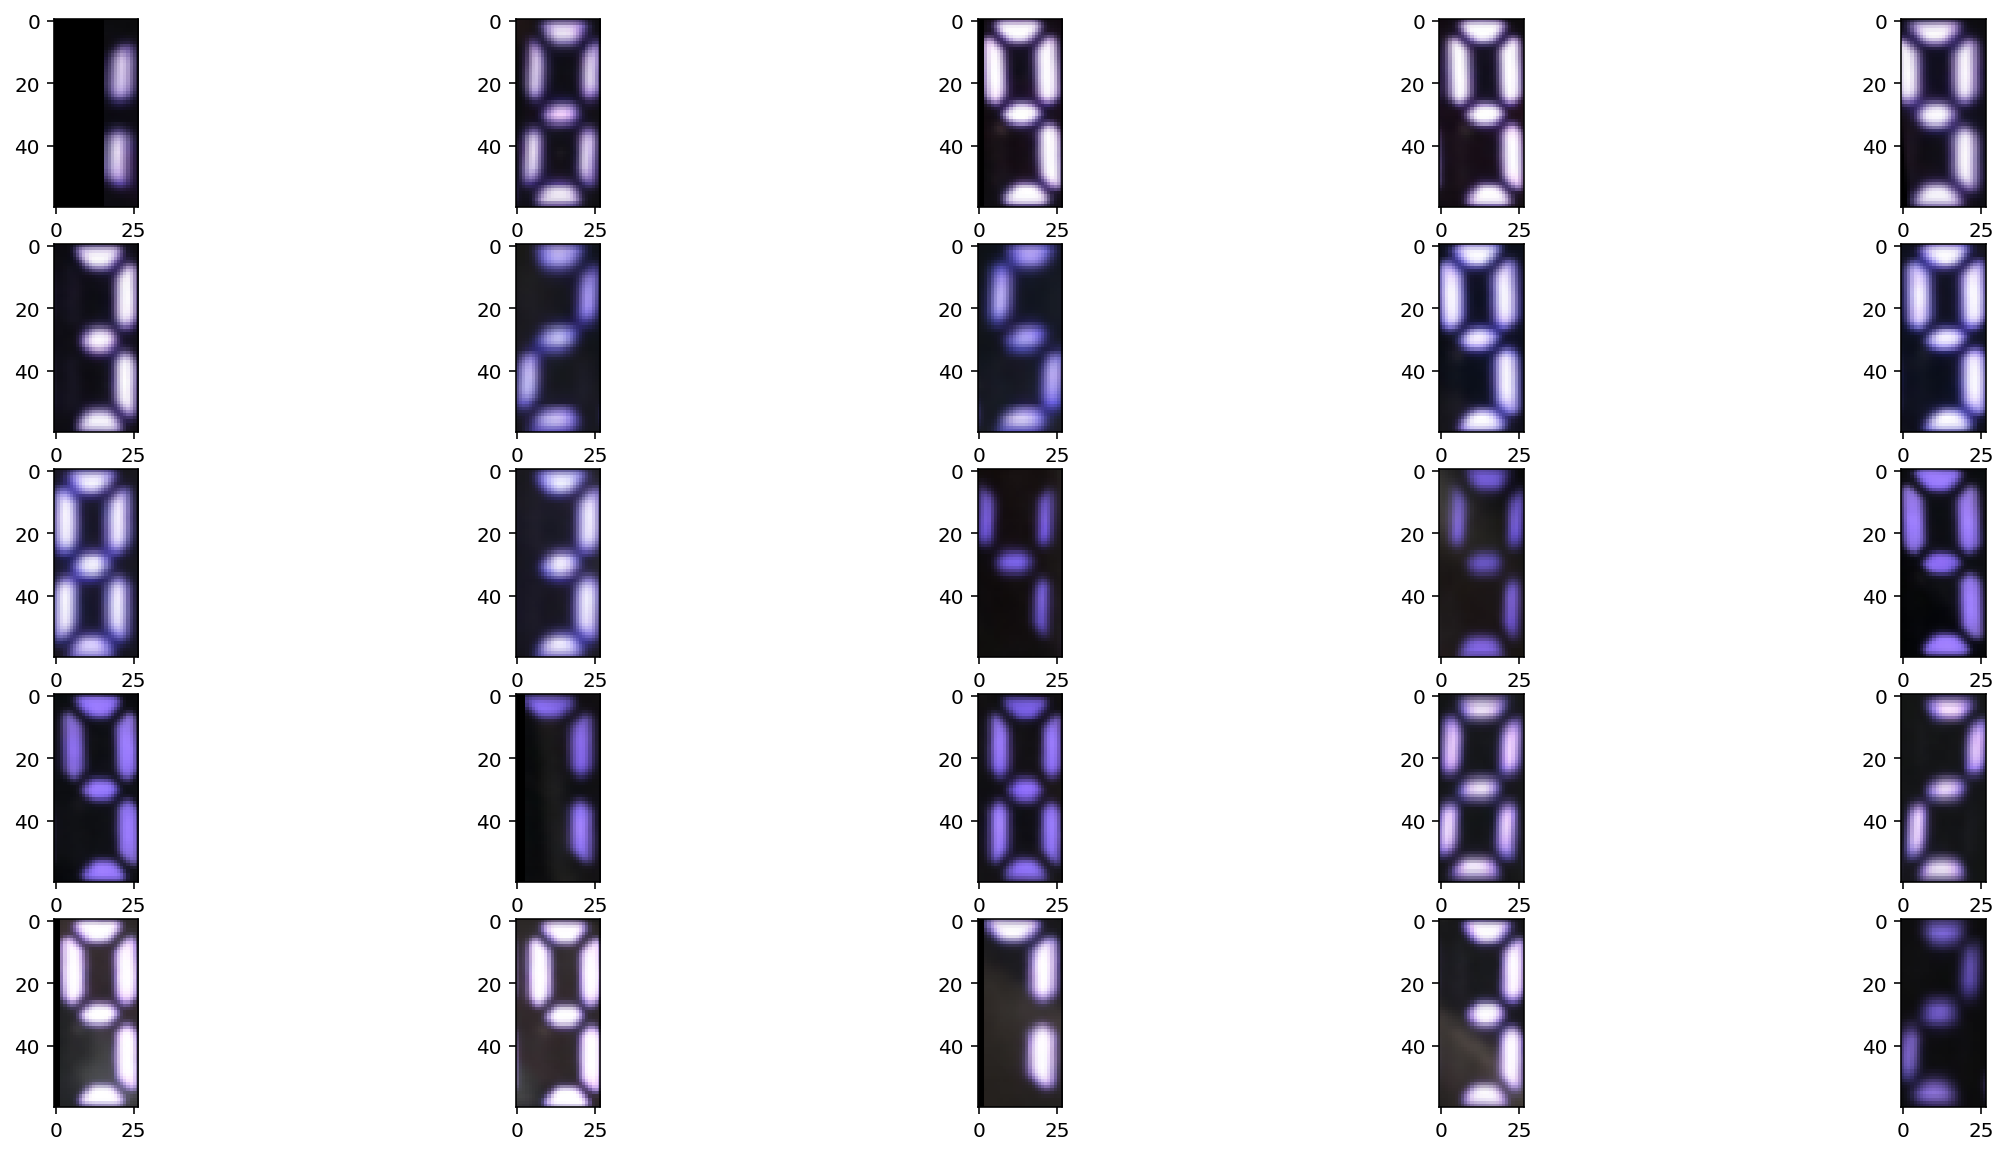

[1, 8, 9, 9, 9, 3, 2, 5, 9, 9, 8, 3, 4, 9, 9, 9, 7, 8, 8, 2, 9, 9, 7, 3, 2]


In [450]:
DIGIT_LOOKUP = [
    [1, 1, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1]]

def read_digit(digit):
    #read a well-framed, single-digit display
    #60 * 27
    gray = cv2.cvtColor(digit, cv2.COLOR_BGR2GRAY)
    th2 = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    total_pixels = np.sum(np.sum(th2))/255
    segment_accumulator = np.zeros(7)    
   
    def region_idx(x, y):
        if 25<=y<=35:
            return 4
        elif y<25:
            if y > 30/27*x:
                if x>=13: return 2
                else: return 3
            else:
                if y > -30/27*x+30: return 2
                else: return 1
        elif y>35:
            if y <= 60 - 30/27*x:
                if x>13: return 5
                else: return 6
            else:
                if y <= 30 + 30/27*x: return 5
                else: return 7
    
    for x in range(27):
        for y in range(60):
            segment_accumulator[region_idx(x, y)-1] += int(th2[y, x]/255)
        
    digit_match = 0
    min_diff = 7
    for digit in range(9, -1, -1):
        expected_segments = DIGIT_LOOKUP[digit]
        #expected fraction of pixels in a segment varies by digit
        num_segments = np.sum(expected_segments)
        segments = [segment_accumulator[i]/total_pixels > 1/(num_segments*2.5) for i in range(7)]
        diff = np.sum([abs(expected_segments[i] - segments[i]) for i in range(7)])
        if diff < min_diff:
            min_diff = diff
            digit_match = digit
    
    return digit_match
    
rec_dgts = []    
plt.figure()
f, ax = plt.subplots(5, 5)
for idx in range(25):
    rec_dgts.append(read_digit(dgts[idx]))
    ax[idx//5][idx%5].imshow(cv2.cvtColor(dgts[idx], cv2.COLOR_BGR2RGB))
plt.show()
print(rec_dgts)


(6.2, 97, 88)


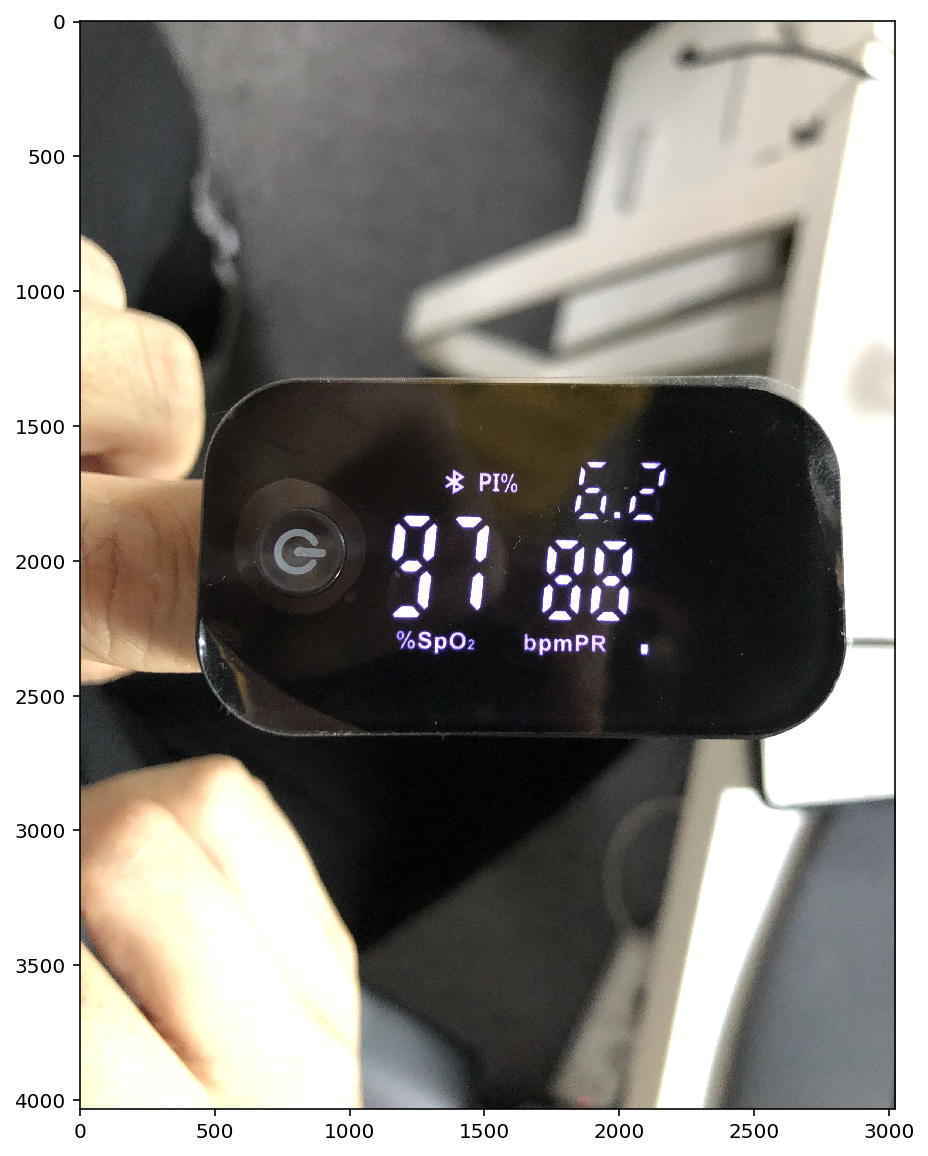

In [467]:
def read_device(image):
    try:
        screen = find_screen(image)
    except Exception:
        print("failed to detect device")
    d1, d2 = find_digits(screen[40:90,200:260], 270, 37, 0.1, True)
    d3, d4 = find_digits(screen[70:145,95:170], 150, 28, 0.1, False)
    d5, d6 = find_digits(screen[85:145, 183:243], 150, 32, 0.1, False)
    d1 = read_digit(d1)
    d2 = read_digit(d2)
    d3 = read_digit(d3)
    d4 = read_digit(d4)
    d5 = read_digit(d5)
    d6 = read_digit(d6)
    reading1 = d1 + d2/10
    reading2 = d3*10 + d4
    reading3 = d5*10 + d6
    return reading1, reading2, reading3

img = cv2.imread('./images/IMG_2843.JPG')
print(read_device(img))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
    
    
    

In [ ]:
    """
    dgray = cv2.cvtColor(digits, cv2.COLOR_BGR2GRAY)
    col_gray = np.mean(dgray, axis=0).astype(np.uint8)
    col_d = np.tile(col_gray, (100,1))
    
    gap_width = 6
    margin_width = 2
        
    darkest_avg = 255
    dark_gap = 0
    for gap in range(8, len(col_gray)-8):
        avg = np.mean(col_gray[int(gap-gap_width/2):int(gap+gap_width/2)]
                     ) - margin_width/gap_width * (np.mean(col_gray[int(gap-gap_width/2-margin_width):int(gap-gap_width/2)])
                                                  +np.mean(col_gray[int(gap+gap_width/2):int(gap+gap_width/2+margin_width)]))  
        if avg < darkest_avg:
            darkest_avg = avg
            dark_gap = gap
    """
    
plt.figure()
f, ax = plt.subplots(5, 5)
for idx in range(25):
    #th2 = cv2.threshold(cv2.cvtColor(dgts[idx+20], cv2.COLOR_BGR2GRAY), 0, 255,
    #    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    d = dgts[idx+20]
    draw_cline(0, 0, 15, 13, d)
    draw_cline(0, 27, 15, 13, d)
    draw_cline(15, 13, 25, 13, d)
    draw_cline(25, 0, 25, 27, d)
    draw_cline(35, 0, 35, 27, d)
    draw_cline(35, 13, 45, 13, d)
    draw_cline(45, 13, 60, 0, d)
    draw_cline(45, 13, 60, 27, d)
    ax[idx//5][idx%5].imshow(cv2.cvtColor(d, cv2.COLOR_BGR2RGB))
plt.show()

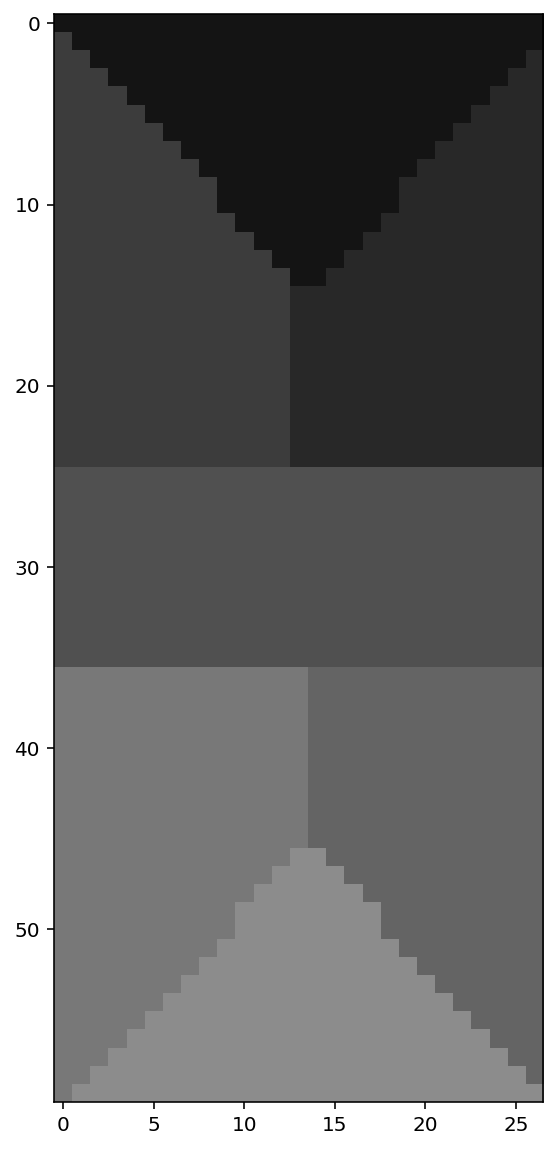

In [382]:
 def region_idx(x, y):
        #determine where a pixel belongs
        if y <= 30:
            if y >= 30/27*x:
                if y >= -30/27*x+30:
                    return 4
                else:
                    return 3
            else:
                if y >= -30/27*x+30:
                    return 2
                else:
                    return 1
        else: return region_idx(x, y-30)+3

def r_idx(x, y):
    if 25<=y<=35:
        return 4
    elif y<25:
        if y > 30/27*x:
            if x>=13: return 2
            else: return 3
        else:
            if y > -30/27*x+30: return 2
            else: return 1
    elif y>35:
        if y <= 60 - 30/27*x:
            if x>13: return 5
            else: return 6
        else:
            if y <= 30 + 30/27*x: return 5
            else: return 7

s = np.zeros((60, 27)).astype(np.uint8)
for x in range(27):
    for y in range(60):
        s[y,x] = r_idx(x, y) * 20

plt.imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
plt.show()

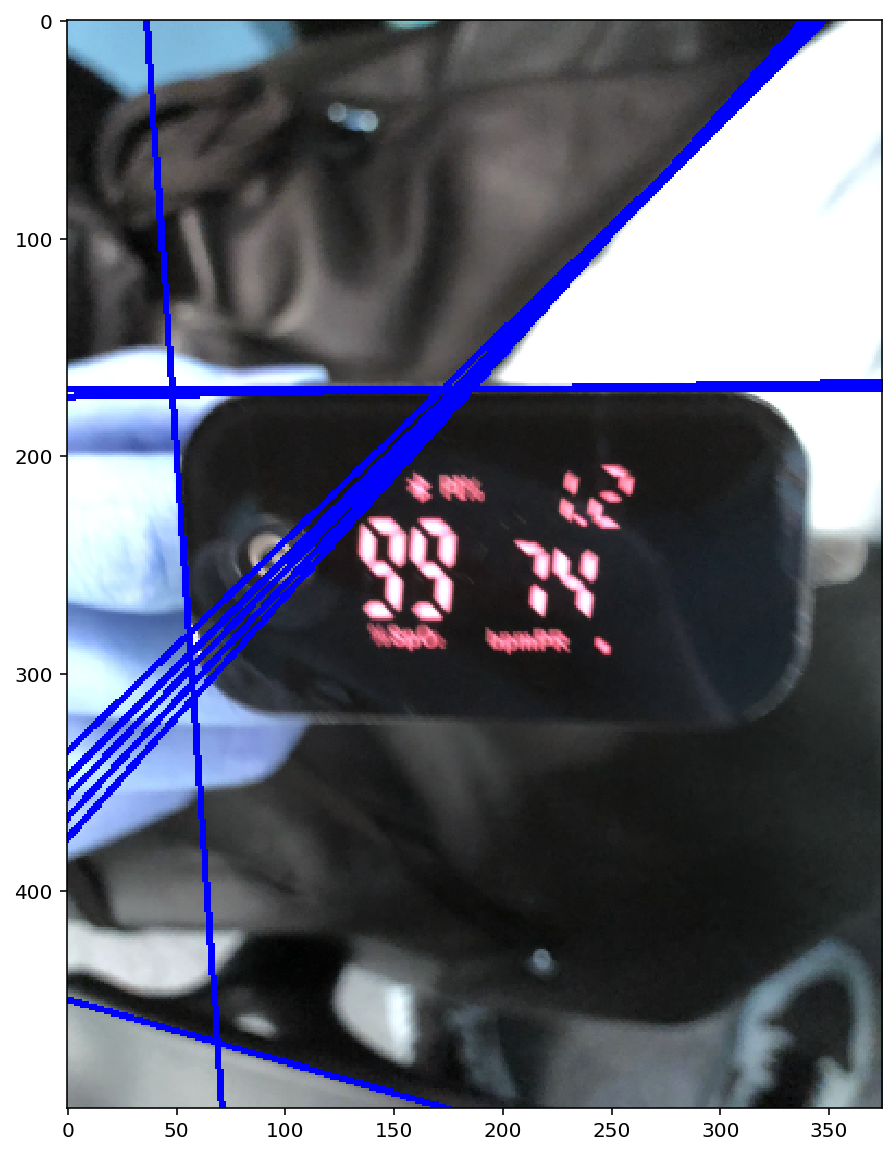

In [86]:
image = cv2.imread('./images/IMG_2836.JPG')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 0, 50, 255)

lines = cv2.HoughLines(edged,1,np.pi/180,90)
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(image,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(image)
plt.show()

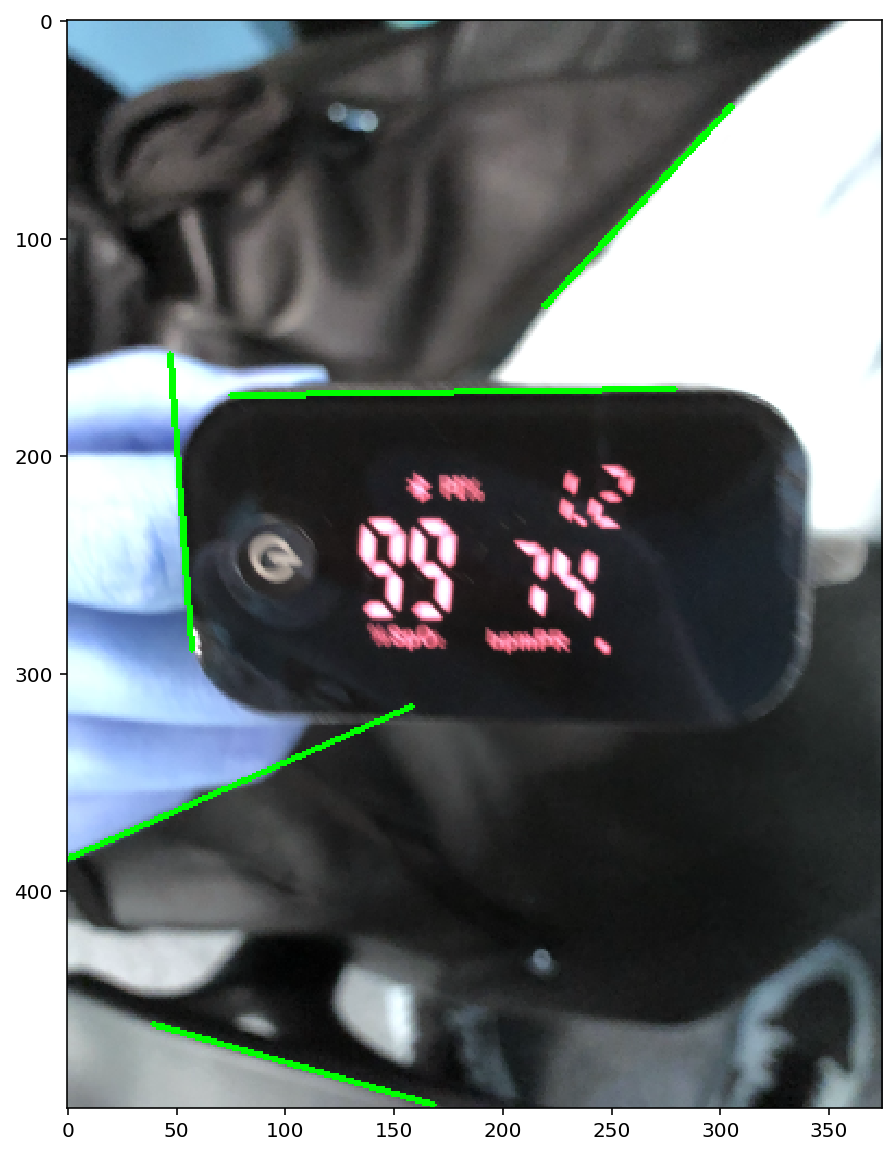

In [81]:
image = cv2.imread('./images/IMG_2836.JPG')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edged = cv2.Canny(blurred, 0, 200, 255)
lines = cv2.HoughLinesP(edged,rho = 1,theta = 1*np.pi/180,
                        threshold = 70,
                        minLineLength = 70,
                        maxLineGap = 50)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
        
plt.imshow(image)
plt.show()

found


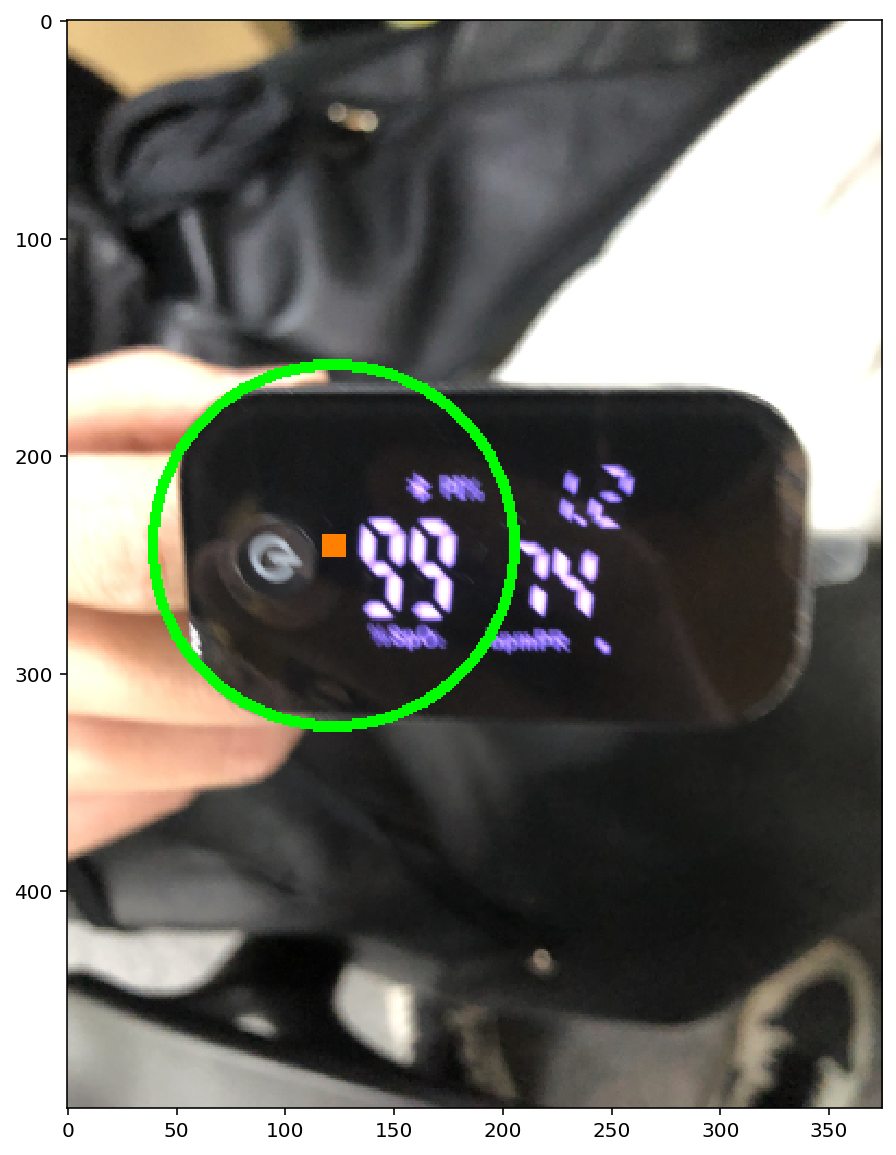

In [111]:
image = cv2.imread('./images/IMG_2836.JPG')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blurred, 0, 200, 255)

# detect circles in the image
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 1.5, 100)
# ensure at least some circles were found
if circles is not None:
	print('found')
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(image, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
    

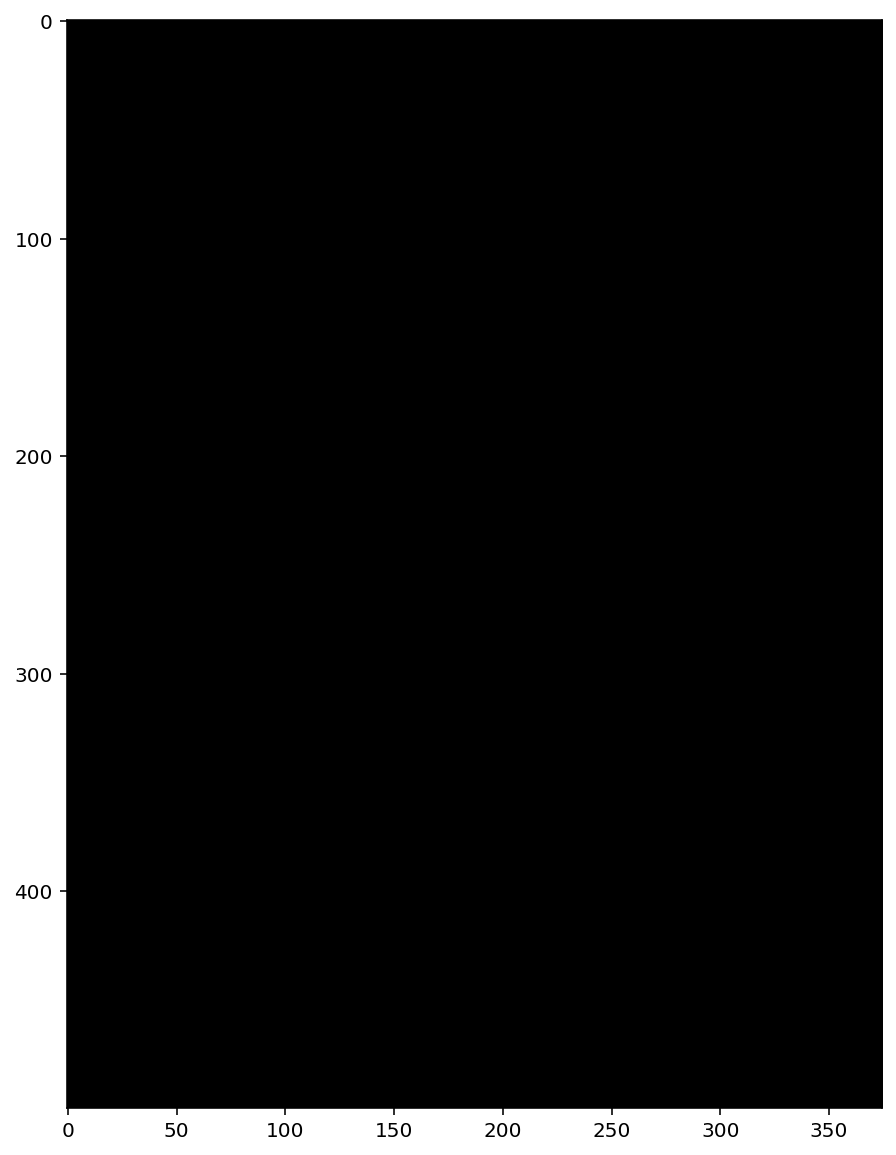

In [142]:
image = cv2.imread('./images/IMG_2836.JPG')
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blurred, 0, 200, 255)


clahe = cv2.createCLAHE(clipLimit=100.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)
blurred = cv2.GaussianBlur(cl1, (5, 5), 10)

lines = cv2.HoughLines(blurred,1,np.pi/180,90)
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(blurred,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
plt.show()

<Figure size 1440x720 with 0 Axes>

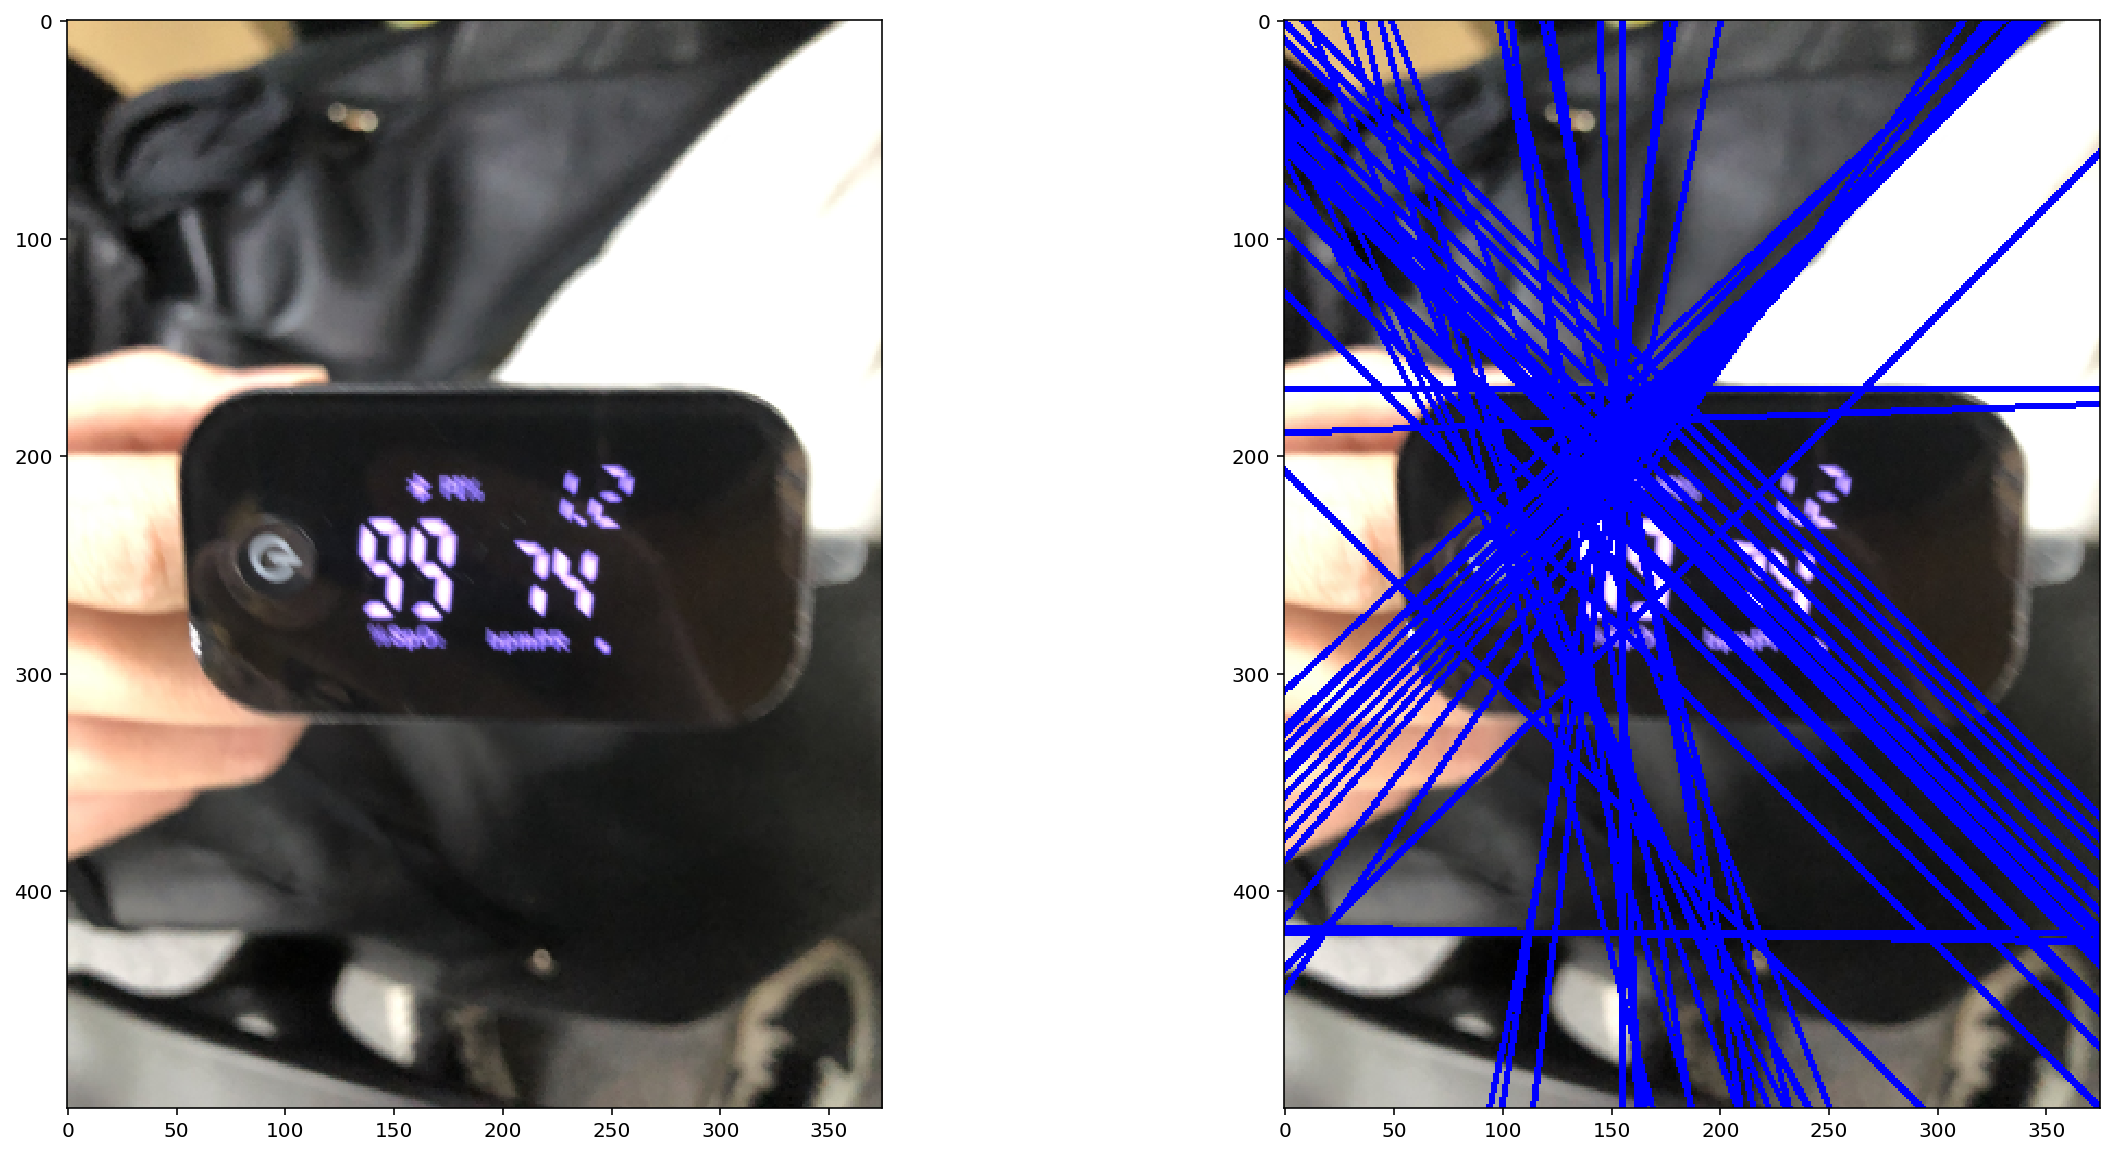

In [88]:
img = cv2.imread('./images/IMG_2836.JPG')
img = imutils.resize(img, height=500)

plt.figure()
f, ax = plt.subplots(1, 2)
#rotated = imutils.rotate(img, 50)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv = cv2.GaussianBlur(hsv, (5, 5), 0)

BLUR = cv2.blur(gray,ksize=(15,15))
dst = cv2.addWeighted(gray, 4, BLUR, -4, 128)     #eliminate background illumination
dst = np.minimum(dst, np.ones(dst.shape) * 255)
dst = np.maximum(dst, np.zeros(dst.shape)).astype(np.uint8)


th2 = cv2.adaptiveThreshold(hsv[:,:,2], 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,31, 2)  


edged = cv2.Canny(th2, 200, 200)

lines = cv2.HoughLines(edged,1,np.pi/180, 1)[0:50]
for line in lines:
    for r, t in line:
        draw_line(r, t, img)


        
#print(np.reshape(c[c>100], ()))

ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

500 375 620 574 dims


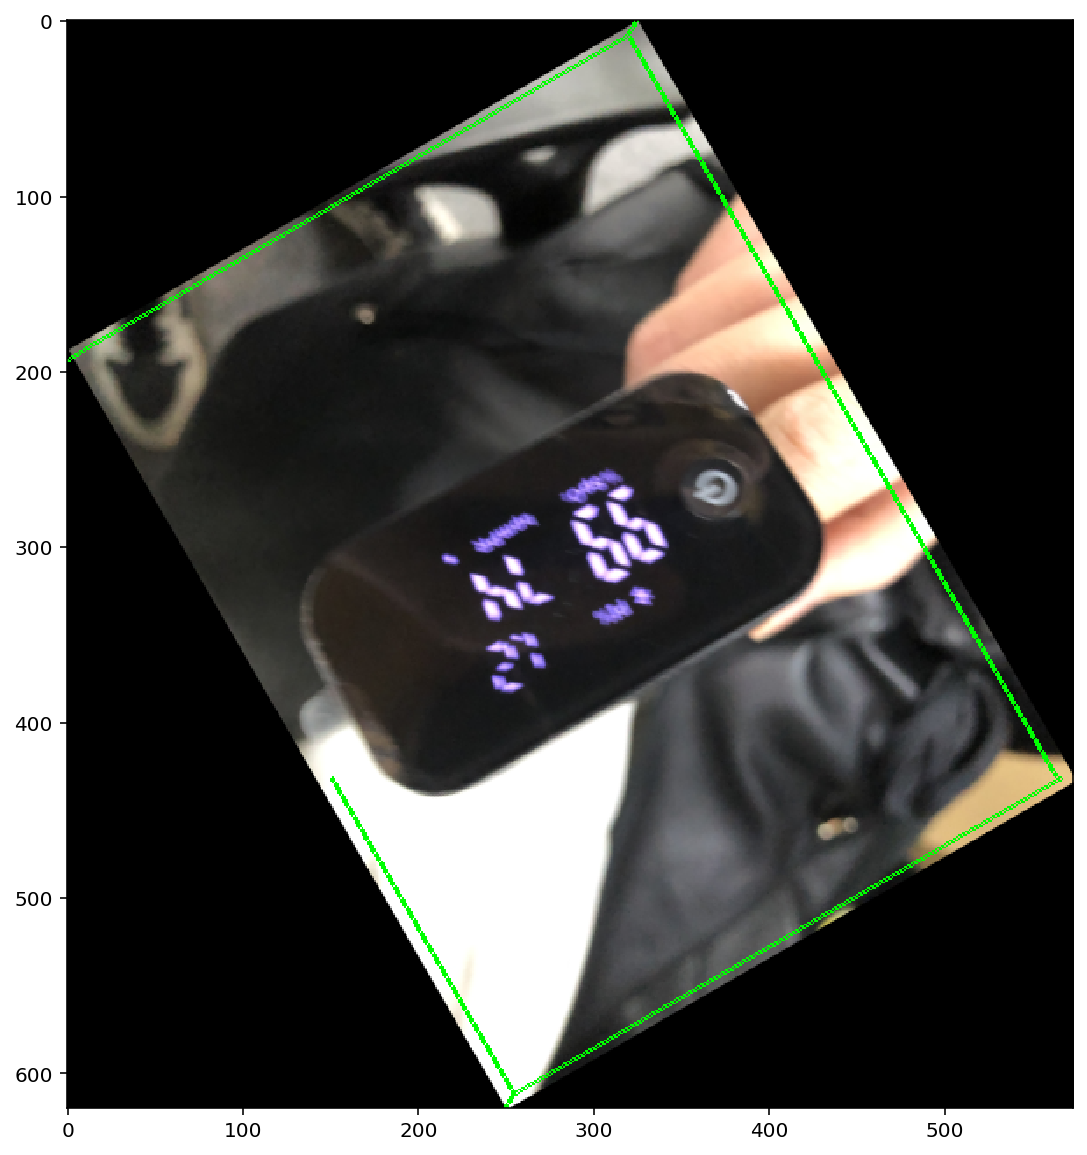

In [38]:
img = cv2.imread('./images/IMG_2836.JPG')
img = imutils.resize(img, height=500)
h, w, _ = img.shape
T = 150
rotated = imutils.rotate_bound(img, T)
hp, wp, _ = rotated.shape
print(h, w, hp, wp, 'dims')


def rotated_bounds(y, theta_, hp, wp, h, w):
    if abs(theta_%360 - 90) <= 2 or abs(theta_%360 - 270) <= 2:
        return 10, wp-10
    if abs(theta_%360) <= 2 or abs(theta_%360 - 180) <= 2:
        return 10, wp-10
    if 90<=theta_%360<180:
        return rotated_bounds(y, theta_-90, hp, wp, w, h)
    if 180<=theta_%360<270:
        return rotated_bounds(y, theta_-180, hp, wp, h, w)
    if 270<=theta_%360<360:
        return rotated_bounds(y, theta_-270, hp, wp, w, h)
    
    theta = theta_/180*np.pi
    
    tan = np.tan(theta)
    b = wp / (1 + tan * h/w)
    a = wp - b
    if 0<=y<int(b*tan):
        xl = int(tan * (a / tan - y))
        xr = wp - int((b * tan - y) / tan)
    elif int(b*tan)<=y<int(hp-b*tan):
        xl = int(tan * (a / tan - y))
        xr = int(xl + w / np.cos(theta))
    elif int(hp-b*tan)<=y<hp:
        xl = int((y - a / tan) / tan)
        xr = int(tan * (a / tan - y) + w / np.cos(theta))
    else:
        xl = 0
        xr = 0
        
    if xr - xl > 20:
        return xl+10, xr-10
    else:
        return int((xr+xl)/2), int((xr+xl)/2)
        
    return xl, xr
    
for y in range(hp):
    xl, xr = rotated_bounds(y, T, hp, wp, h, w)
    #print(xl, xr, y)
    cv2.circle(rotated, (xl, y), 1, (0, 255, 0), 1)
    cv2.circle(rotated, (xr, y), 1, (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.show()


500 375 620 574 dims


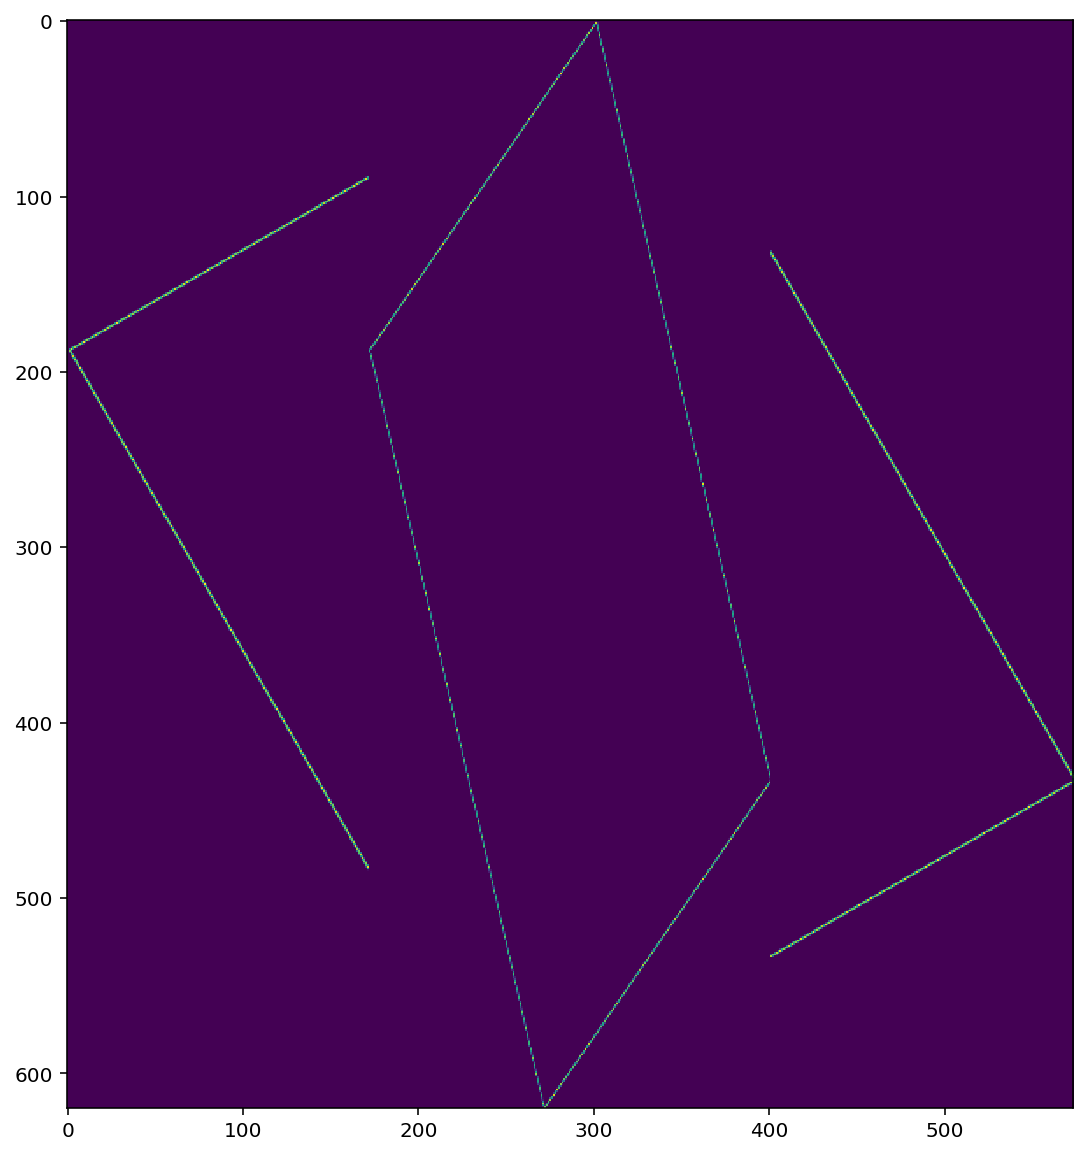

In [46]:
img = cv2.imread('./images/IMG_2836.JPG')
img = imutils.resize(img, height=500)
h, w, _ = img.shape
T = 150
rotated = imutils.rotate_bound(img, T)
hp, wp, _ = rotated.shape
print(h, w, hp, wp, 'dims')

frame = np.zeros((h, w))
frame[:, 0] = 255
frame[:, -1] = 255
frame[0, :] = 255
frame[-1, :] = 255
rotated_frame = imutils.rotate_bound(frame, T)
hf, wf = rotated_frame.shape


trimmed_frame = cv2.resize(rotated_frame, (int(wf*0.4), hf))
rotated_frame[:, int(wf*0.3):int(wf*0.3)+int(wf*0.4)] = trimmed_frame


plt.imshow(rotated_frame)
plt.show()

<Figure size 1440x720 with 0 Axes>

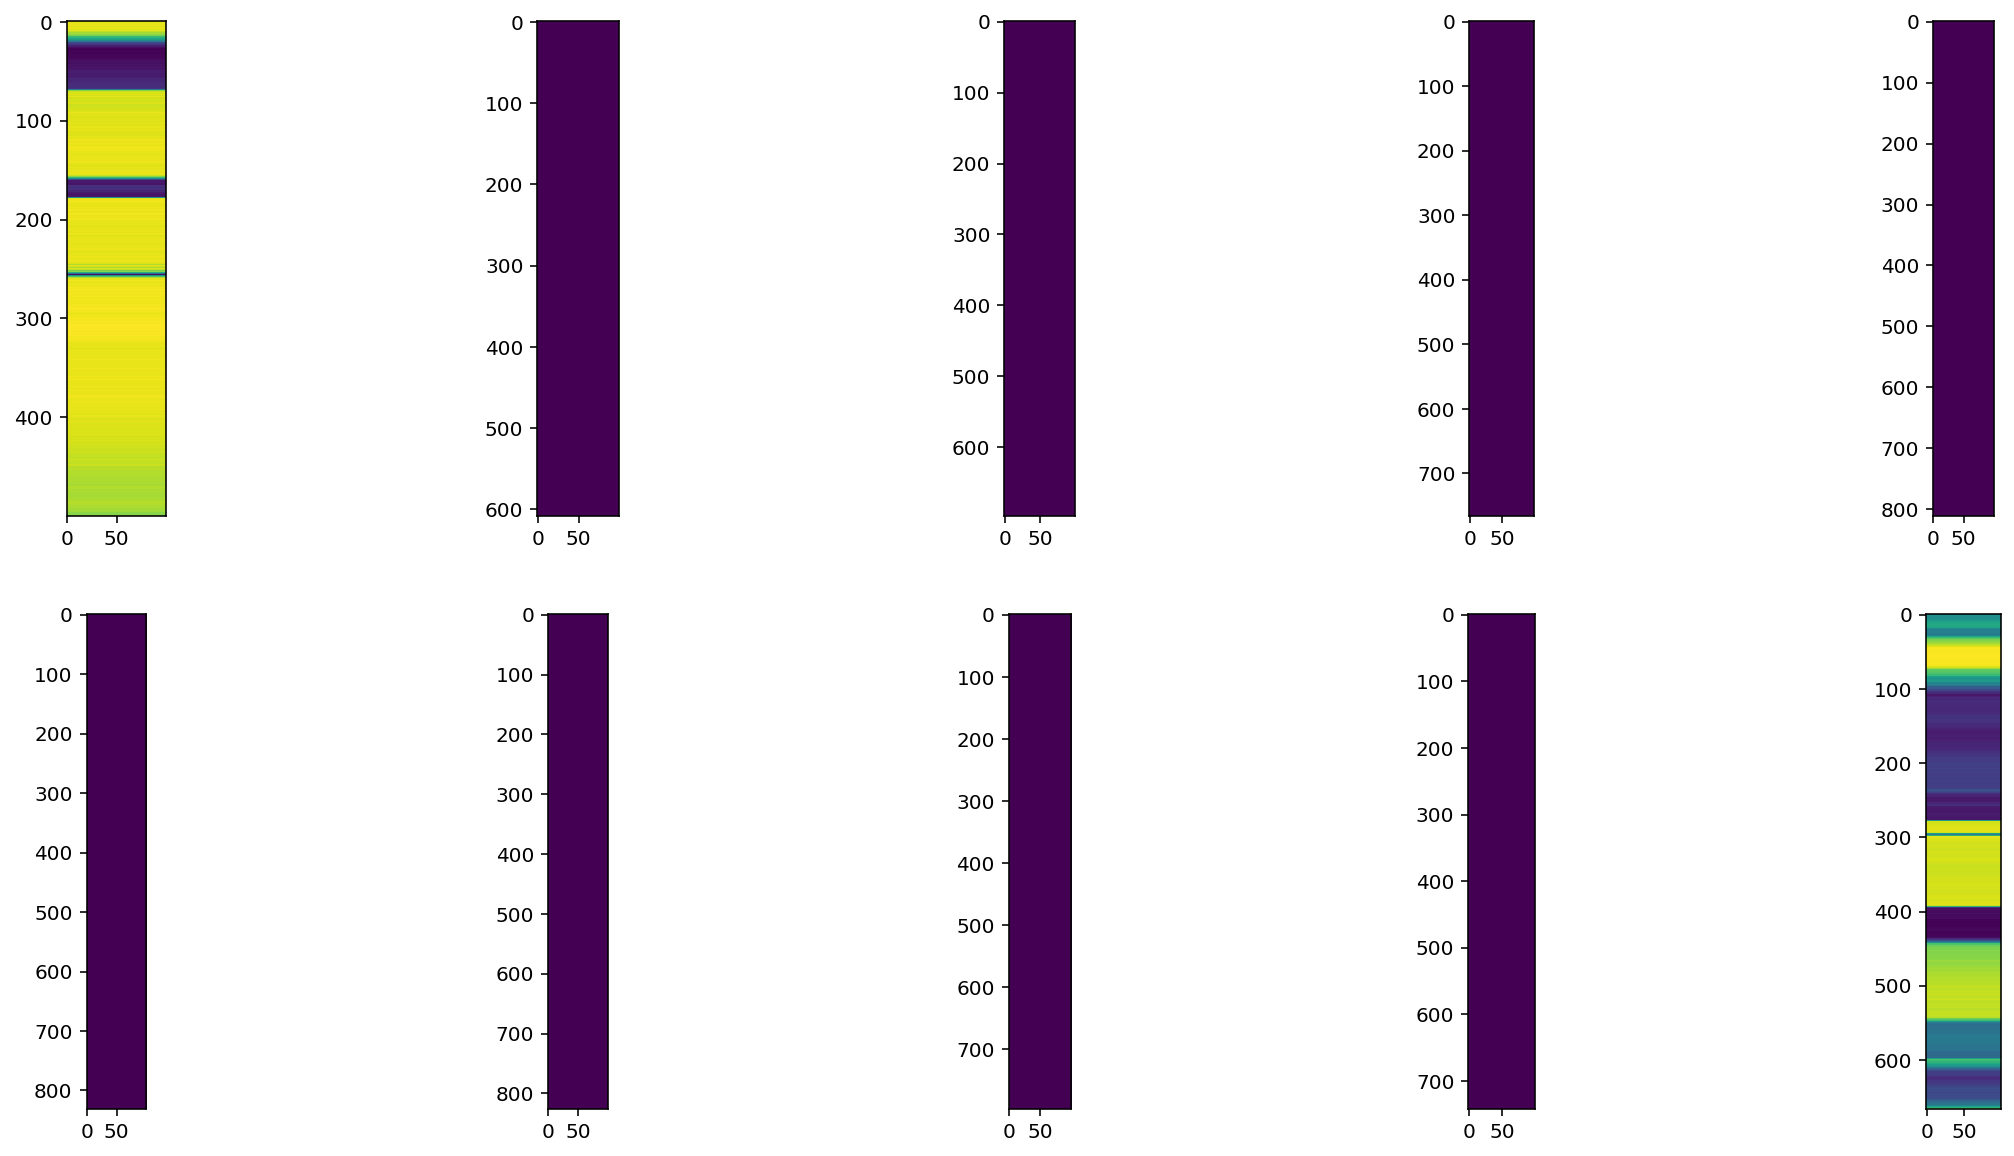

In [8]:
angle_step = 10
horizontal_diffs = [None] * (360//angle_step) 
#hsvim = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#row_color = np.array([hsvim[i,:,2].max(axis=0) - hsvim[i,:,2].min(axis=0) for i in range(len(hsvim))])
#row_color = np.expand_dims(row_color, axis=1)

img = cv2.imread('./images/IMG_2836.JPG')
img = imutils.resize(img, height=500)
h, w, _ = img.shape
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
v_channel = hsv[:, :, 2]

trim_ = 0.3

for step in range(360//angle_step):
    angle = step * angle_step
    rotated = imutils.rotate_bound(v_channel, angle)
    hp, wp = rotated.shape
    #def lb(y): return max(rotated_bounds(y, angle, hp, wp, h, w)[0], trim)
    #def rb(y): return min(rotated_bounds(y, angle, hp, wp, h, w)[1], wp-trim)
    hor_diffs = np.zeros(hp)
    for i in range(hp):
        lb_, rb_ = rotated_bounds(y, angle, hp, wp, h, w)
        lb = int(lb_ + abs(lb_-rb_)*trim_)
        rb = int(rb_ - abs(lb_-rb_)*trim_)
        valid_row = rotated[i, lb:rb]
        if len(valid_row): hor_diffs[i] = valid_row.max(axis=0) - valid_row.min(axis=0)
        else: hor_diffs[i] = 255
    horizontal_diffs[step] = hor_diffs

plt.figure()
f, ax = plt.subplots(2, 5)
for idx in range(10):
    diffs = np.array([horizontal_diffs[idx]])
    display = np.tile(np.transpose(diffs), (1, 100))
    ax[idx//5][idx%5].imshow(display)
plt.show()

In [ ]:
def find_screen2(org_image):
    org_image = imutils.resize(org_image, height=500)
    imh = org_image.shape[0]
    imw = org_image.shape[1]
    cropL = 0
    cropR = len(org_image[0])
    
    image = org_image[:, cropL:cropR]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,31, 2)  
    edged = cv2.Canny(th2, 0, 100, 255)
    
    lines = cv2.HoughLines(edged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
    lines = np.append(lines, [[[i]] for i in range(len(lines))], axis=2) #mark by order of feature strength
    
    #merge similar lines
    idx = 0 
    while idx < len(lines):
        for jdx in range(idx):
            ri, ti, _ = lines[idx][0]
            rj, tj, _ = lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                lines = np.delete(lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #find pairs of horizontal parallel lines
    parallel_lines = []
    for i in range(len(lines)):
        for j in range(i):
            ri, ti, si = lines[i][0]
            rj, tj, sj = lines[j][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            #parallel, some distance apart, horizontal
            if dt < 0.1 and 75<dp<200: # and 1.40<ti<1.70: 
                parallel_lines.append([ri, ti, si, rj, tj, sj])

    parallel_lines.sort(key=lambda p: (p[2]*p[2]+p[5]*p[5]))  #sort by feature strength
    print(len(parallel_lines))
    parallel_lines = parallel_lines[:100]
    
    for pair in parallel_lines:
        draw_line(*pair[:2], org_image)
        draw_line(*pair[3:5], org_image)

    sector_angle = 10
    horizontal 
   
    return org_image